#### 1. Бинаризация (лучше адаптивная, если фон неравномерный; либо метод Оцу).

#### 2. Открытие (Opening), чтобы убрать мелкие точки.

#### 3. Закрытие (Closing), если нужно «залечить» пропуски внутри букв.

#### 4. (Опционально) Медианный фильтр до бинаризации, если исходный шум имеет «соль и перец» и мешает порогу.

#### 5. Проверка результата визуально (смотрим, исчезли ли точки шума, не разрушился ли текст).

#### 6. (Опционально) Расчёт метрик: среднеквадратичное отклонение (MSE) между «чистым» эталоном и результатом или другие показатели (PSNR, SSIM), если есть эталон. Иначе — просто визуальное сравнение.

In [6]:
import cv2
import numpy as np

def mse(img1, img2):
    """
    Вычисляет среднеквадратичную ошибку (MSE) между двумя изображениями.
    Предполагается, что img1 и img2 одного размера.
    """
    # Преобразуем к float и считаем сумму квадратов разностей
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

def main():
    # 1. Считываем исходное изображение в градациях серого
    img_gray = cv2.imread("text-c-crc.png", cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print("Не удалось открыть файл imageC.png")
        return

    # 2. Изображение 1: только бинаризация (метод Оцу)
    _, bin_image = cv2.threshold(
        img_gray, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 3. Изображение 2: морфология (или другой фильтр), затем бинаризация
    #    Например, морфологическое "открытие" (OPEN) для сглаживания шума
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # морфологическая операция на исходном СЕРОМ изображении
    morph_img = cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, kernel)

    # Теперь снова порог (Оцу) на результат морфологии
    _, morph_bin = cv2.threshold(
        morph_img, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 4. Сравнение двух результатов (bin_image и morph_bin)
    # Предполагаем, что у них одинаковые размеры
    mse_val = mse(bin_image, morph_bin)

    print("MSE между чисто-бинаризованным и морфологически отфильтрованным изображением:", mse_val)

    # 5. Сохраняем результаты для наглядности
    cv2.imwrite("result_bin.png", bin_image)
    cv2.imwrite("result_morph.png", morph_bin)

if __name__ == "__main__":
    main()


MSE между чисто-бинаризованным и морфологически отфильтрованным изображением: 1524.2873376623377


In [7]:
import cv2
import numpy as np

# 1. Считываем изображение в градациях серого
img = cv2.imread("text-c-crc.png", cv2.IMREAD_GRAYSCALE)

# 2. (Опционально) можно применить медианный фильтр для сглаживания шума
# img = cv2.medianBlur(img, 3)

# 3. Создаём структурный элемент (kernel) для морфологии
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# 4. Применяем операцию Opening (erode -> dilate) прямо на сером изображении
opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# 5. Применяем операцию Closing (dilate -> erode) на результате Opening
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

# 6. Сохраняем результат
cv2.imwrite("result_no_threshold.png", closed)


True

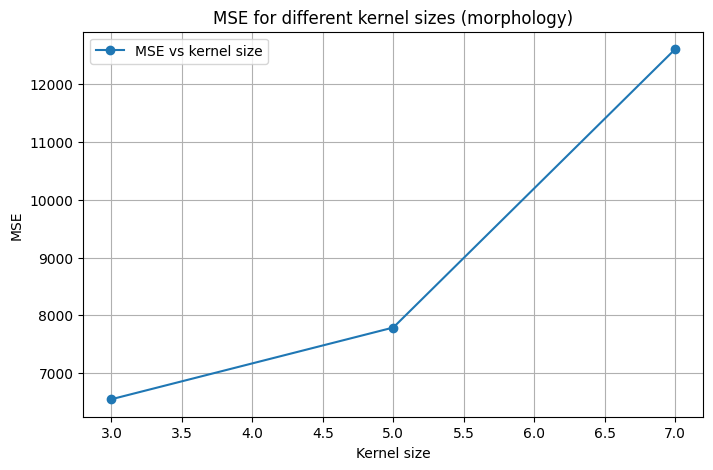

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mse(img1, img2):
    # Предполагаем, что оба — numpy-массивы одинакового размера, grayscale
    diff = img1.astype(np.float32) - img2.astype(np.float32)
    return np.mean(diff**2)

# 1. Загрузка
img_noisy = cv2.imread("text-c-crc.png", cv2.IMREAD_GRAYSCALE)
img_clean = cv2.imread("text-c-true.png", cv2.IMREAD_GRAYSCALE)  # эталон, если есть

kernel_sizes = [3, 5, 7]
mse_values = []

for k in kernel_sizes:
    # 2. Бинаризация (к примеру, метод Оцу)
    _, bin_img = cv2.threshold(img_noisy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Морфология
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    # Допустим, делаем Opening
    opened = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
    # Дополнительно Closing
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # 4. Считаем MSE
    # Если нет эталона, можно mse(closed, bin_img) — разница с исходной бинарной
    current_mse = mse(closed, img_clean)
    mse_values.append(current_mse)

# 5. Строим график
plt.figure(figsize=(8,5))
plt.plot(kernel_sizes, mse_values, marker='o', label="MSE vs kernel size")
plt.xlabel("Kernel size")
plt.ylabel("MSE")
plt.title("MSE for different kernel sizes (morphology)")
plt.legend()
plt.grid(True)
plt.show()


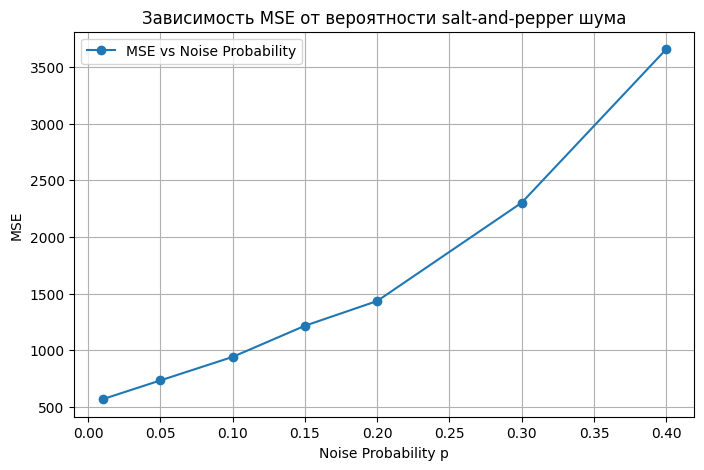

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def add_salt_pepper_noise(img, prob):
    """
    Добавляет salt-and-pepper шум с вероятностью prob к серому изображению img.
    prob ~ доля пикселей, которые будут заменены на шум.
    Пример: при prob=0.1, 10% пикселей станут либо 0 (чёрный), либо 255 (белый).
    """
    # Создадим копию, чтобы не портить исходник
    noisy = img.copy()
    # Генерируем для каждого пикселя случайное число от 0 до 1
    rand = np.random.rand(*img.shape)
    
    # Порог для «соли» (white)
    noisy[rand < (prob / 2)] = 0
    # Порог для «перца» (black)
    noisy[(rand >= (prob / 2)) & (rand < prob)] = 255
    
    return noisy

def mse(img1, img2):
    """
    Среднеквадратичное отклонение (MSE) между двумя изображениями (одинакового размера).
    """
    diff = img1.astype(np.float32) - img2.astype(np.float32)
    return np.mean(diff**2)

# 1. Считываем «чистое» изображение в градациях серого
img_original = cv2.imread("text-c-true.png", cv2.IMREAD_GRAYSCALE)
if img_original is None:
    raise FileNotFoundError("Не удалось загрузить image_clean.png")

# 2. Задаём список вероятностей шума
prob_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4]  # Можно расширить

mse_values = []

# Создаём структурный элемент для морфологии (3x3)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

for p in prob_values:
    # 3. Генерируем зашумлённое изображение
    img_noisy = add_salt_pepper_noise(img_original, p)

    # 4. Применяем фильтр
    # 4.1 Бинаризация (опционально) — если хотим делать морфологию на бинарном
    # _, bin_img = cv2.threshold(img_noisy, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # opening = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
    # filtered = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Или применим медианный фильтр напрямую:
    filtered = cv2.medianBlur(img_noisy, 3)

    # 5. Считаем MSE с исходным «чистым» изображением
    current_mse = mse(filtered, img_original)
    mse_values.append(current_mse)

# 6. Строим график MSE(p)
plt.figure(figsize=(8,5))
plt.plot(prob_values, mse_values, marker='o', label='MSE vs Noise Probability')
plt.xlabel("Noise Probability p")
plt.ylabel("MSE")
plt.title("Зависимость MSE от вероятности salt-and-pepper шума")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
import numpy as np

def add_salt_pepper_noise(img, p):
    """
    Добавляет salt-and-pepper шум с вероятностью p к каждому пикселю.
    p ~ доля пикселей, которые станут белыми или чёрными.
    Половина из p -> чёрные, половина -> белые.
    """
    noisy = img.copy()
    rand = np.random.rand(*img.shape)

    # Половина пикселей из p заменим на 0 (чёрный)
    noisy[rand < p/2] = 0
    # Вторая половина из p заменим на 255 (белый)
    noisy[(rand >= p/2) & (rand < p)] = 255

    return noisy


In [12]:
import numpy as np

def add_crc_noise(img, p):
    """
    С вероятностью 4p выбираем центр кружка диаметром 3 и заливаем этот кружок 
    (окружность радиуса 1) белым (255) или чёрным (0).
    """
    noisy = img.copy()
    rows, cols = img.shape

    # Генерируем для каждого пикселя случайное число
    rand = np.random.rand(rows, cols)

    # Для каждого пикселя проверяем, будет ли он центром круга
    for i in range(rows):
        for j in range(cols):
            if rand[i, j] < 4 * p:
                # Случайно выберем белый или чёрный
                color = 0 if np.random.rand() < 0.5 else 255

                # Заливаем кружок радиуса 1 (диаметр 3)
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni = i + di
                        nj = j + dj
                        if 0 <= ni < rows and 0 <= nj < cols:
                            # Проверяем, действительно ли внутри круга (окружности)
                            # Для круга радиуса 1 можно использовать dist^2 <= 1^2
                            if di*di + dj*dj <= 1:
                                noisy[ni, nj] = color

    return noisy


In [13]:
def mse(img1, img2):
    diff = img1.astype(np.float32) - img2.astype(np.float32)
    return np.mean(diff**2)


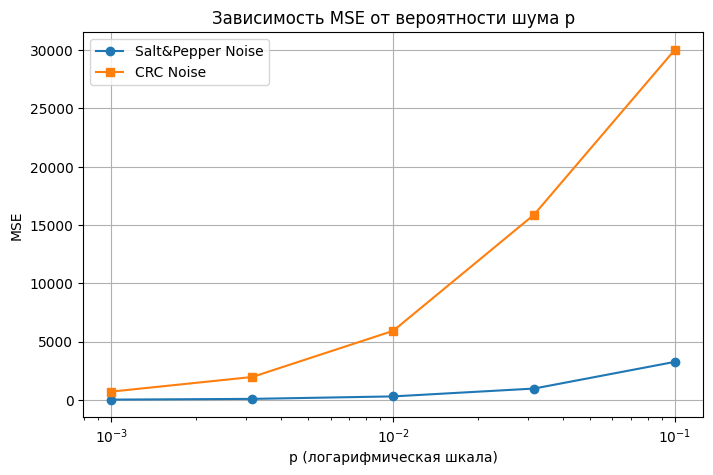

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Загружаем "чистое" изображение (в градациях серого)
    img_original = cv2.imread("text-c-true.png", cv2.IMREAD_GRAYSCALE)
    if img_original is None:
        raise FileNotFoundError("Не удалось загрузить image_clean.png")

    p_values = np.logspace(-3, -1, num=5)  # [0.001, 0.01, 0.1]

    mse_sp = []
    mse_crc = []

    for p in p_values:
        # --- Шум "соль и перец" ---
        img_sp = add_salt_pepper_noise(img_original, p)
        # Фильтрация, если нужно (например, медианная)
        # img_sp_filtered = cv2.medianBlur(img_sp, 3)
        # Или оставляем как есть (если просто хотим сравнить "шум" vs original)

        sp_mse_val = mse(img_sp, img_original)
        mse_sp.append(sp_mse_val)

        # --- Шум "crc" ---
        img_crc = add_crc_noise(img_original, p)
        # Аналогичная фильтрация, если нужно
        # img_crc_filtered = cv2.medianBlur(img_crc, 3)

        crc_mse_val = mse(img_crc, img_original)
        mse_crc.append(crc_mse_val)

    # Строим графики
    plt.figure(figsize=(8,5))
    plt.plot(p_values, mse_sp, marker='o', label="Salt&Pepper Noise")
    plt.plot(p_values, mse_crc, marker='s', label="CRC Noise")
    plt.xscale('log')  # по заданию p идёт от 1e-3 до 1e-1
    plt.xlabel("p (логарифмическая шкала)")
    plt.ylabel("MSE")
    plt.title("Зависимость MSE от вероятности шума p")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


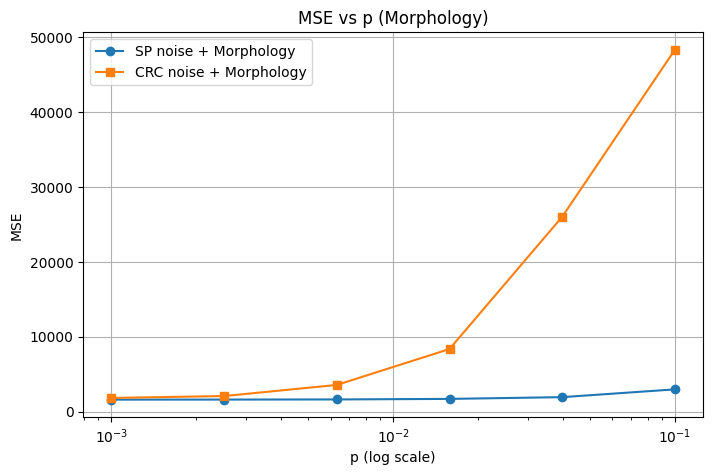

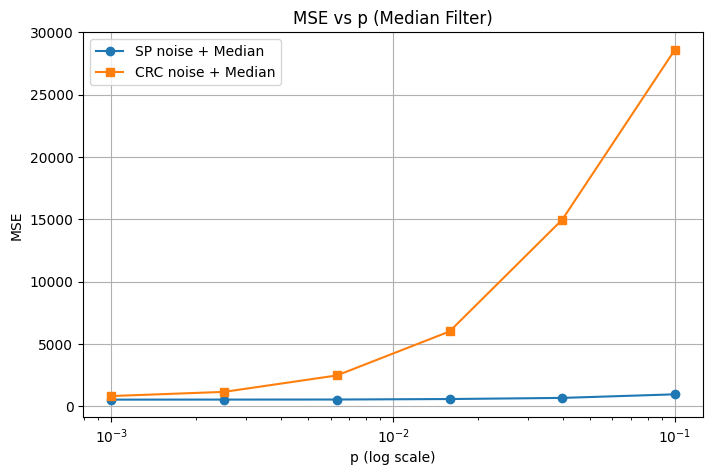

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def add_salt_pepper_noise(img, p):
    """
    Добавляет salt-and-pepper шум с вероятностью p.
    p ~ доля пикселей, заменяемых на 0 или 255.
    """
    noisy = img.copy()
    rand = np.random.rand(*img.shape)
    # Половина из p -> чёрные
    noisy[rand < p/2] = 0
    # Вторая половина из p -> белые
    noisy[(rand >= p/2) & (rand < p)] = 255
    return noisy

def add_crc_noise(img, p):
    """
    С вероятностью 4p выбираем центр кружка диаметром 3 пикселей
    и закрашиваем его белым (255) или чёрным (0).
    """
    noisy = img.copy()
    rows, cols = img.shape
    rand = np.random.rand(rows, cols)

    for i in range(rows):
        for j in range(cols):
            if rand[i, j] < 4 * p:
                # Выбираем цвет (белый/чёрный) с равной вероятностью
                color = 0 if np.random.rand() < 0.5 else 255

                # Заливаем окружность радиуса 1 (диаметр 3)
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni = i + di
                        nj = j + dj
                        if 0 <= ni < rows and 0 <= nj < cols:
                            # Проверим, что внутри круга (dist^2 <= 1)
                            if di*di + dj*dj <= 1:
                                noisy[ni, nj] = color

    return noisy

def mse(img1, img2):
    """
    Среднеквадратичное отклонение между двумя изображениями.
    """
    diff = img1.astype(np.float32) - img2.astype(np.float32)
    return np.mean(diff**2)

def morphological_filter(img):
    """
    Пример морфологического фильтра:
    1) Бинаризация (Оцу)
    2) Opening (3x3)
    3) Closing (3x3)
    Возвращает результирующее изображение (также бинарное).
    """
    # Бинаризация
    _, bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

    # Opening
    opened = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
    # Closing
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    return closed

def median_filter(img):
    """
    Пример медианного фильтра (3x3).
    """
    filtered = cv2.medianBlur(img, 3)
    return filtered

def main():
    # Загружаем исходное "чистое" изображение (grayscale)
    img_original = cv2.imread("text-c-true.png", cv2.IMREAD_GRAYSCALE)
    if img_original is None:
        raise FileNotFoundError("Не удалось загрузить image_clean.png")

    # Список вероятностей p в логарифмическом диапазоне (например, от 1e-3 до 1e-1)
    p_values = np.logspace(-3, -1, num=6)  # 6 точек: [1e-3, 3.16e-3, 1e-2, 3.16e-2, 1e-1, ...]

    # Массивы для хранения MSE
    # Morphology
    mse_morph_sp = []
    mse_morph_crc = []

    # Median
    mse_med_sp = []
    mse_med_crc = []

    for p in p_values:
        # 1) Шум "соль и перец"
        sp_noisy = add_salt_pepper_noise(img_original, p)
        # a) морфология
        sp_morph = morphological_filter(sp_noisy)
        # Преобразуем sp_morph в тот же формат, что и img_original (если sp_morph бинарное)
        # Для MSE корректнее, если оба 8-бит grayscale.
        # Морфология вернёт 0/255, но это нормально.
        mse_morph_sp.append(mse(sp_morph, img_original))

        # b) медианный
        sp_median = median_filter(sp_noisy)
        mse_med_sp.append(mse(sp_median, img_original))

        # 2) Шум "crc"
        crc_noisy = add_crc_noise(img_original, p)
        # a) морфология
        crc_morph = morphological_filter(crc_noisy)
        mse_morph_crc.append(mse(crc_morph, img_original))

        # b) медианный
        crc_median = median_filter(crc_noisy)
        mse_med_crc.append(mse(crc_median, img_original))

    # ============= График 1: Морфология =============
    plt.figure(figsize=(8,5))
    plt.plot(p_values, mse_morph_sp, marker='o', label="SP noise + Morphology")
    plt.plot(p_values, mse_morph_crc, marker='s', label="CRC noise + Morphology")
    plt.xscale('log')
    plt.xlabel("p (log scale)")
    plt.ylabel("MSE")
    plt.title("MSE vs p (Morphology)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ============= График 2: Медианный фильтр =============
    plt.figure(figsize=(8,5))
    plt.plot(p_values, mse_med_sp, marker='o', label="SP noise + Median")
    plt.plot(p_values, mse_med_crc, marker='s', label="CRC noise + Median")
    plt.xscale('log')
    plt.xlabel("p (log scale)")
    plt.ylabel("MSE")
    plt.title("MSE vs p (Median Filter)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
